# Anomaly Detection of MNIST by AutoEncoder (PyTorch)

In [18]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [2]:
data_path = pathlib.Path().cwd().parents[1] / 'data' / 'external' / 'mnist'
model_storage_path = pathlib.Path().cwd().parent / 'models'
result_storage_path = pathlib.Path().cwd().parent / 'results'

In [3]:
model_path = model_storage_path / 'autoencoder.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [5]:
epochs = 100
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-5

In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # [0,1] => [-1,1]
    ])

In [7]:
train_dataset = MNIST(str(data_path), download=False, train=True, transform=transformer)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = AutoEncoder().to(device)

In [11]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [12]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    )

In [14]:
loss_list = []
for epoch in range(1, 1+epochs):
    for data in train_loader:
        img, _ = data
        x = img.view(img.size(0), -1)
        x = Variable(x).to(device)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
        # logging
        loss_list.append(loss)
    
    print(f'Epoch [{epoch}/{epochs}] \t Loss: {loss:.4f}')

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, str(result_storage_path / f'image_{epoch}.png'))
np.save(str(result_storage_path / 'loss_list.npy'), np.array(loss_list))

Epoch [1/100] 	 Loss: 0.2010
Epoch [2/100] 	 Loss: 0.2038
Epoch [3/100] 	 Loss: 0.1843
Epoch [4/100] 	 Loss: 0.1823
Epoch [5/100] 	 Loss: 0.1652
Epoch [6/100] 	 Loss: 0.1687
Epoch [7/100] 	 Loss: 0.1766
Epoch [8/100] 	 Loss: 0.1610
Epoch [9/100] 	 Loss: 0.1698
Epoch [10/100] 	 Loss: 0.1705
Epoch [11/100] 	 Loss: 0.1584
Epoch [12/100] 	 Loss: 0.1550
Epoch [13/100] 	 Loss: 0.1672
Epoch [14/100] 	 Loss: 0.1477
Epoch [15/100] 	 Loss: 0.1649
Epoch [16/100] 	 Loss: 0.1661
Epoch [17/100] 	 Loss: 0.1616
Epoch [18/100] 	 Loss: 0.1423
Epoch [19/100] 	 Loss: 0.1460
Epoch [20/100] 	 Loss: 0.1544
Epoch [21/100] 	 Loss: 0.1377
Epoch [22/100] 	 Loss: 0.1592
Epoch [23/100] 	 Loss: 0.1531
Epoch [24/100] 	 Loss: 0.1606
Epoch [25/100] 	 Loss: 0.1551
Epoch [26/100] 	 Loss: 0.1568
Epoch [27/100] 	 Loss: 0.1509
Epoch [28/100] 	 Loss: 0.1505
Epoch [29/100] 	 Loss: 0.1500
Epoch [30/100] 	 Loss: 0.1554
Epoch [31/100] 	 Loss: 0.1483
Epoch [32/100] 	 Loss: 0.1481
Epoch [33/100] 	 Loss: 0.1492
Epoch [34/100] 	 Lo

KeyboardInterrupt: 

In [16]:
torch.save(model.state_dict(), str(model_path))

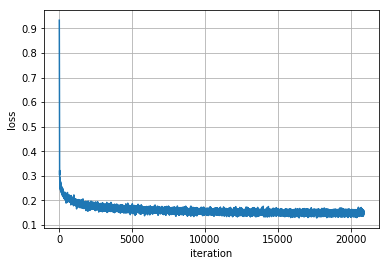

In [19]:
#loss_list = np.loadstr(result_storage_path / 'loss_list.npy'))
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()

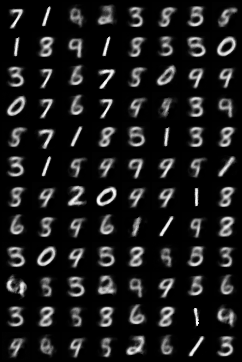

In [24]:
from IPython.display import Image, display_png
Image(filename=str(result_storage_path / 'image_10.png'))

In [27]:
batch_size_test = 10000

In [28]:
model.load_state_dict(torch.load(str(model_path)))

In [29]:
test_dataset = MNIST(str(data_path), download=False, train=False, transform=transformer)

In [30]:
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [31]:
images, labels = iter(test_loader).next()
images = images.view(batch_size_test, -1)

In [36]:
z = model.encoder(Variable(images).to(device))
z = z.cpu().data.numpy()

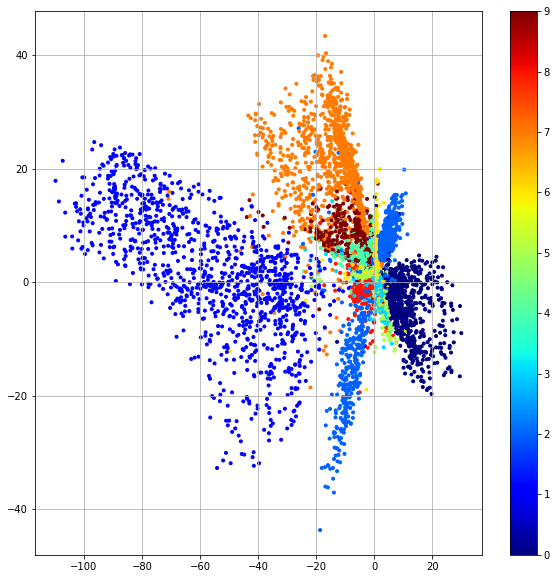

In [37]:
import pylab
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()